In [2]:
from pylab import *
import numpy as np  
import scipy.signal as signal
from scipy.signal import butter, lfilter, freqz
import matplotlib  
#matplotlib.use('Agg') # necessary for headless mode  
# see http://stackoverflow.com/a/3054314/3524528
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline


import uhd

print(uhd.usrp)

<module 'uhd.usrp' from '/home/aalmela/anaconda3/lib/python3.7/site-packages/uhd/usrp.py'>


In [2]:
# Funcion para graficar el espectro en funcion del timepo
def plotSG(x,Fs):
    plt.specgram(x, NFFT=2048, Fs=Fs)  
    plt.xlabel("Time (s)")  
    plt.ylabel("Frequency (Hz)") 
    plt.ylim(-Fs/2, Fs/2)  
    #plt.plot("x1_spec.pdf", bbox_inches='tight', pad_inches=0.5)  
    plt.xlim(0,len(x)/Fs)  
    plt.ticklabel_format(style='plain', axis='y' )  
    plt.show()
    plt.close()
    
    
def plotSGS(x,Fs):
    plt.specgram(x, NFFT=2048, Fs=Fs)  
    plt.xlabel("Time (s)")  
    plt.ylabel("Frequency (Hz)") 
    plt.ylim(0, Fs/2)  
    #plt.plot("x1_spec.pdf", bbox_inches='tight', pad_inches=0.5)  
    plt.xlim(0,len(x)/Fs)  
    plt.ticklabel_format(style='plain', axis='y' )  
    plt.show()
    plt.close()    
    
def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(-40, 5)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title) 
    
    
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



In [41]:
F_station = int(2450e6)  # Pick a radio station

# We capture at an offset to avoid DC spike
F_offset  = 250e3                 # Offset to capture at  
Fc        = F_station - F_offset  # Capture center frequency 

Fs = int(10e6)         # Sample rate  
N  = int(50e3)          # Samples to capture

print('Freq samples = {:1.3f} Msps'.format(Fs/1e6))

print('Windows time = {:1.2f} s'.format(N/Fs))
print('sample  step = {:1.2e} us'.format(1e6/Fs))

print('Min Freq     = {:1.2f} Hz'.format(Fs/N))
print('Max Freq     = {:1.2f} KHz'.format(Fs/1e3))

Freq samples = 10.000 Msps
Windows time = 0.01 s
sample  step = 1.00e-01 us
Min Freq     = 200.00 Hz
Max Freq     = 10000.00 KHz


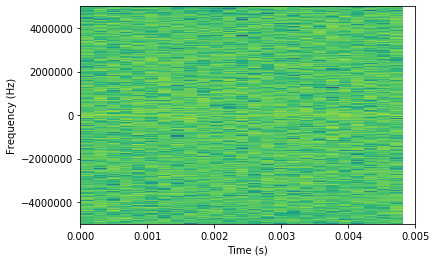

In [120]:
"""RX samples and write to file"""
usrp = uhd.usrp.MultiUSRP("type=b200")

samps = usrp.recv_num_samps(
    N, # Number of samples
    Fc, # Frequency in Hz
    Fs, # Sampling rate
    [0], # Receive on channel 0
    50, # 100 dB of RX gain
)

x1 = np.array(samps[0]).astype("complex128")

plotSG(x1,Fs)

In [115]:
print(len(samps[0]))

50000


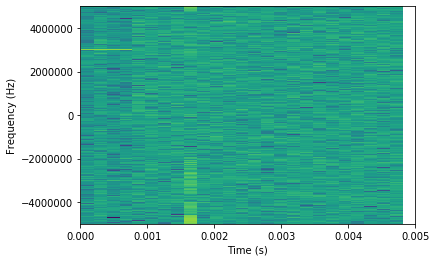

In [53]:
# Convert samples to a numpy array
x1 = np.array(samps[0]).astype("complex128")

plotSG(x1,Fs)

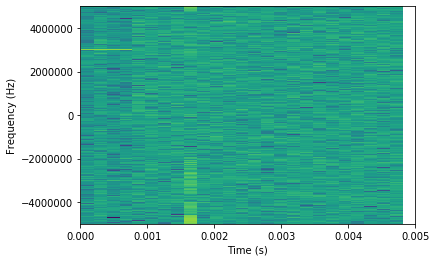

In [51]:
plotSG(x1,Fs)

In [52]:
# To mix the data down, generate a digital complex exponential 
# (with the same length as x1) with phase -F_offset/Fs

fc1 = np.exp(-1.0j*2.0*np.pi* F_offset*np.arange(len(x1))/Fs)  

print(fc1[0:10])

[1.        +0.j         0.98768834-0.15643447j 0.95105652-0.30901699j
 0.89100652-0.4539905j  0.80901699-0.58778525j 0.70710678-0.70710678j
 0.58778525-0.80901699j 0.4539905 -0.89100652j 0.30901699-0.95105652j
 0.15643447-0.98768834j]


In [ ]:
# Now, just multiply x1 and the digital complex expontential
x2 = x1 * fc1  


plotSG(x2,Fs)

In [ ]:
# An FM broadcast signal has a bandwidth of 200 kHz
f_bw = 200000 
cutoff      = f_bw                # Desired cutoff frequency, Hz
trans_width = (Fs/2-f_bw)/8  # Width of transition from pass band to stop band, Hz
n_taps      = 128  # Size of the FIR filter.

# Use Remez algorithm to design filter coefficients
lpf = signal.remez(n_taps, [0, cutoff, cutoff + trans_width, Fs/2], [1,0], Hz=Fs)  

w, h = signal.freqz(lpf, [1], worN=2000)
plot_response(Fs, w, h, "Low-pass Filter")
plt.show()



# Filtro pasabajos para eliminar canales adyacentes 
x3  = signal.lfilter(lpf, 1.0, x2)

plotSG(x3,Fs)
print((x3[100]))

In [ ]:
dec_rate = int(Fs / f_bw)  
print(dec_rate)
x4 = x3[0::dec_rate]  
# Calculate the new sampling rate
Fs_y = Fs/dec_rate

print('New Freq samples = {:1.0f} sps'.format(Fs_y))

plotSG(x4,Fs_y)

print(abs(x3[100:110]))
print(abs(x4[int(100/dec_rate):int(100/dec_rate)+2]))
print(len(x4))

In [ ]:
# Plot the constellation of x4.  What does it look like?
plt.scatter(np.real(x4[0:50000]), np.imag(x4[0:50000]), color="red", alpha=0.05)  
plt.title("x4")  
plt.xlabel("Real")  
plt.xlim(-1.1,1.1)  
plt.ylabel("Imag")  
plt.ylim(-1.1,1.1)  
#plt.plot("x4_const.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  


In [ ]:
### Polar discriminator
y5 = x4[1:] * np.conj(x4[:-1])  
x5 = np.angle(y5)  


print(x5[100])
plt.plot(x5[:100])
plt.show()

# Note: x5 is now an array of real, not complex, values
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(x5, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x5")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)  
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  

plotSGS(x5,Fs_y)

In [ ]:
# The de-emphasis filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html
# Given a signal 'x5' (in a numpy array) with sampling rate Fs_y
d = Fs_y * 75e-6   # Calculate the # of samples to hit the -3dB point  
x = np.exp(-1/d)   # Calculate the decay between each sample  
b = [1-x]          # Create the filter coefficients  
a = [1,-x]  
x6 = signal.lfilter(b,a,x5)  

# Note: x5 is now an array of real, not complex, values
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(x6, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("Output De-emphasis")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)  
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  

In [ ]:
# Find a decimation rate to achieve audio sampling rate between 44-48 kHz
audio_freq  = 44100.0
dec_audio   = int(Fs_y/audio_freq) 
Fs_audio   = Fs_y / dec_audio
print(Fs_audio)
x7 = signal.decimate(x6, dec_audio)  


# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(x7, NFFT=2048, Fs=Fs_audio, color="blue")  
plt.title("x7")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)  
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  
 
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()

plt.close()  

In [ ]:
highcut = 15e3  # Cut-off frequency of the filter
lowcut = 100
fs = Fs_audio
# w = fc / (Fs_audio / 2) # Normalize the frequency
# b, a = signal.butter(10, w, 'low')
# output = signal.filtfilt(b, a, x7)


# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.semilogx([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
plt.show()



output = butter_bandpass_filter(x7, lowcut, highcut, Fs_audio, order=6)
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(output, NFFT=2048, Fs=Fs_audio, color="blue")  
plt.title("Output")  
plt.axvspan(lowcut,        highcut,     color="green", alpha=0.2)  
plt.axvspan(lowcut-10,     highcut+10,     color="red", alpha=0.4)  

 
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()

plt.close()  

In [ ]:
# Scale audio to adjust volume
output *= 0.5 / np.max(np.abs(x7))  
# Save to file as 16-bit signed single-channel audio samples
#output.astype("int16").tofile("wbfm-mono.raw")  

plt.plot(output)

In [ ]:
from scipy.io import wavfile

sampleRate = 45600


wavfile.write('output.wav', sampleRate, output)